# Modified Simulation
- Including Feedback loop, considering the connection between success and further lucky events
- Including actual survey data for talent, capital and socio economic status

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
# Load the data from CSV
data_path = 'processed_ess_data.csv'
processed_ess_data = pd.read_csv(data_path)

# sample 100 agents
filtered_ess_data = processed_ess_data.sample(n=100, random_state=1)

# Display the first few rows of the dataframe to ensure it's loaded correctly
print(filtered_ess_data.head())


       idno  ses_index  talent_index   capital
906   68719   0.796215           1.0  3.333333
267   54824   0.941776           1.0  8.333333
1070  72501   0.558224           0.0  3.333333
1409  79858   0.796215           1.0  5.000000
403   57569   0.702329           0.0  2.500000


In [3]:
# Extract the relevant columns
ses_index = filtered_ess_data['ses_index'].values
talent_index = filtered_ess_data['talent_index'].values
capital = filtered_ess_data['capital'].values

# Ensure the number of agents matches the length of the extracted columns
num_agents = len(talent_index)


Text(0.5, 1.0, 'Distribution of Talent Index among subset of 100 Agents')

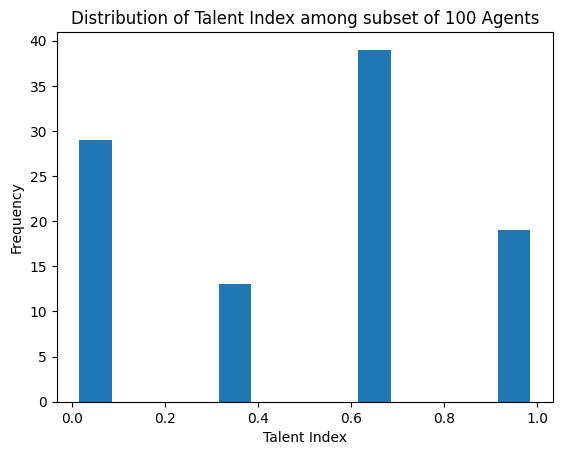

In [4]:
# plot of variable distribution
plt.hist(talent_index, rwidth=0.7)  
plt.ylabel('Frequency')
plt.xlabel('Talent Index')
plt.title('Distribution of Talent Index among subset of 100 Agents')

Text(0.5, 1.0, 'Distribution of SES Index among subset of 100 Agents')

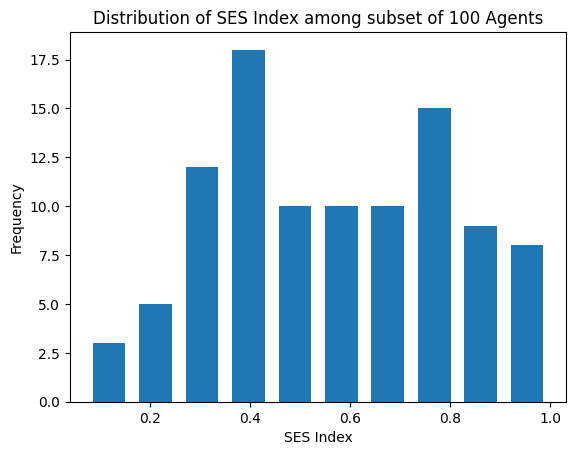

In [5]:
# plot of variable distribution
plt.hist(ses_index, rwidth=0.7)  
plt.ylabel('Frequency')
plt.xlabel('SES Index')
plt.title('Distribution of SES Index among subset of 100 Agents')

Text(0.5, 1.0, 'Distribution of Capital among subset of 100 Agents')

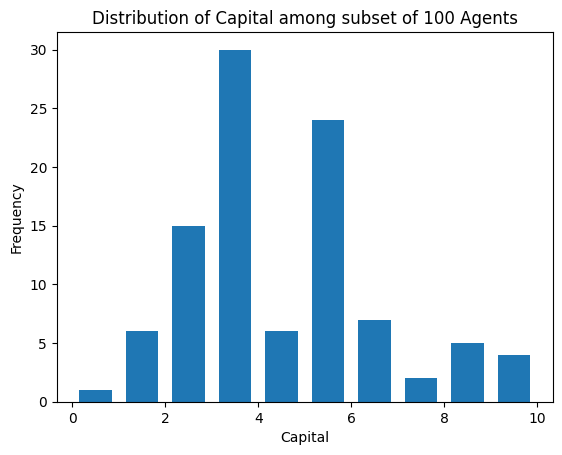

In [6]:
# plot of variable distribution
plt.hist(capital, rwidth=0.7)  
plt.ylabel('Frequency')
plt.xlabel('Capital')
plt.title('Distribution of Capital among subset of 100 Agents')

In [7]:
# Parameters
grid_size = 20
num_lucky_events = 25
num_unlucky_events = 25
num_steps = 80

In [8]:
# Data collection lists
capital_changes = []
event_types = []
talent_values = []

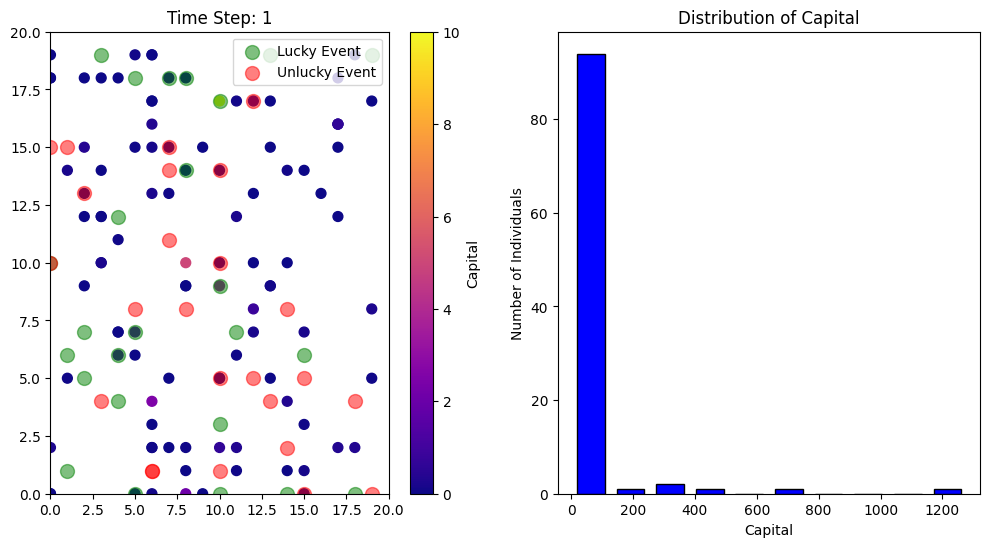

In [9]:
# Generate random positions for agents
positions = np.random.randint(0, grid_size, (num_agents, 2))

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_xlim(0, grid_size)
ax1.set_ylim(0, grid_size)
ax2.set_xlim(0, capital.max()) *2

# Create a single colorbar
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=capital.min(), vmax=capital.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('Capital')

# Initial scatter plot
normalized_capitals = (capital - capital.min()) / (capital.max() - capital.min())
colors = plt.cm.plasma(normalized_capitals)
scat_agents = ax1.scatter(positions[:, 0], positions[:, 1], c=colors, s=50, edgecolor='k')

# Function to update the simulation
def update(frame):
    global positions, capital

    # Generate random event points
    lucky_events = np.random.randint(0, grid_size, (num_lucky_events, 2))
    unlucky_events = np.random.randint(0, grid_size, (num_unlucky_events, 2))

    # Calculate probability of lucky events based on current capital, ses_index, and talent_index
    probabilities = (capital + ses_index + talent_index) / 3
    probabilities = np.clip(probabilities, 0, 1)

    # Check for lucky events
    for event in lucky_events:
        for i, pos in enumerate(positions):
            if np.array_equal(event, pos):
                if np.random.rand() < probabilities[i]:
                    capital_change = capital[i] * 2 - capital[i]
                    capital[i] *= 2
                    capital_changes.append(capital_change)
                    event_types.append('lucky')
                    talent_values.append(talent_index[i])

    # Check for unlucky events
    for event in unlucky_events:
        for i, pos in enumerate(positions):
            if np.array_equal(event, pos):
                capital_change = capital[i] / 2 - capital[i]
                capital[i] /= 2
                capital_changes.append(capital_change)
                event_types.append('unlucky')
                talent_values.append(talent_index[i])

    # Update colors based on capitals
    normalized_capitals = (capital - capital.min()) / (capital.max() - capital.min())
    colors = plt.cm.plasma(normalized_capitals)

    # Update scatter plot
    scat_agents.set_offsets(positions)
    scat_agents.set_color(colors)

    # Clear previous event points
    for coll in ax1.collections[1:]:
        coll.remove()

    # Plot new event points
    ax1.scatter(lucky_events[:, 0], lucky_events[:, 1], c='green', s=100, alpha=0.5, label='Lucky Event')
    ax1.scatter(unlucky_events[:, 0], unlucky_events[:, 1], c='red', s=100, alpha=0.5, label='Unlucky Event')

    # Update legend
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper right')

    # Clear and update histogram
    ax2.cla()
    ax2.hist(capital, rwidth=0.7, color='blue', edgecolor='black') #, bins=20
    ax2.set_title('Distribution of Capital')
    ax2.set_xlabel('Capital')
    ax2.set_ylabel('Number of Individuals')
    ax1.set_title(f'Time Step: {frame + 1}')

# Create animation and keep a reference to it
mod_ani = animation.FuncAnimation(fig, update, frames=num_steps, repeat=False, interval=500)
# mod_ani.save('../results/modified_simulation.mp4', writer="ffmpeg")


# Display animation in Jupyter notebook
HTML(mod_ani.to_jshtml())


In [10]:
# Convert collected data to a DataFrame
event_data = pd.DataFrame({
    'capital_change': capital_changes,
    'event_type': event_types,
    'talent_value': talent_values
})

# Save the data for later analysis
event_data.to_csv('data_modified_simulation.csv', index=False)

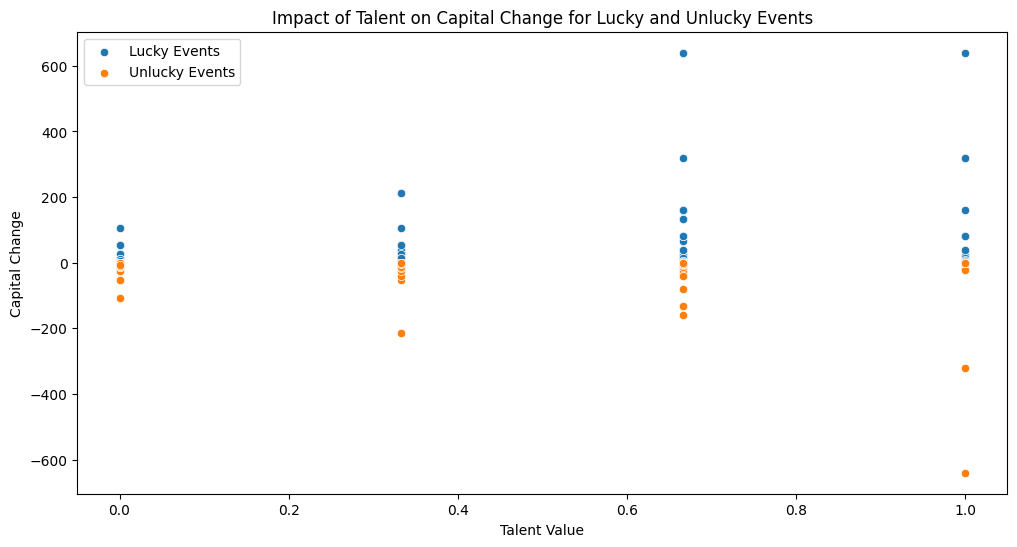

Correlation between Talent and Capital Change for Lucky Events: 0.07351625530951363
Correlation between Talent and Capital Change for Unlucky Events: -0.06943498585541312
Correlation between Talent and Capital Change: 0.0343175594166023


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Separate the data into lucky and unlucky events
lucky_events = event_data[event_data['event_type'] == 'lucky']
unlucky_events = event_data[event_data['event_type'] == 'unlucky']

# Plot the impact of talent on capital changes for lucky events
plt.figure(figsize=(12, 6))
sns.scatterplot(x='talent_value', y='capital_change', data=lucky_events, label='Lucky Events')
sns.scatterplot(x='talent_value', y='capital_change', data=unlucky_events, label='Unlucky Events')
plt.xlabel('Talent Value')
plt.ylabel('Capital Change')
plt.title('Impact of Talent on Capital Change for Lucky and Unlucky Events')
plt.legend()
plt.show()

# Calculate the correlation between talent and capital change
correlation_lucky = lucky_events['talent_value'].corr(lucky_events['capital_change'])
correlation_unlucky = unlucky_events['talent_value'].corr(unlucky_events['capital_change'])
correlation_talent_success = event_data["talent_value"].corr(event_data['capital_change'])

print(f"Correlation between Talent and Capital Change for Lucky Events: {correlation_lucky}")
print(f"Correlation between Talent and Capital Change for Unlucky Events: {correlation_unlucky}")
print(f"Correlation between Talent and Capital Change: {correlation_talent_success}")
